In [1]:
!pip install pyLDAvis==2.1.2

     |████████████████████████████████| 1.6 MB 5.1 MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97738 sha256=62bde8e582bf47f97a8183722d251da598901dca8f99f83d3a1b88f8f0ab035a
  Stored in directory: /root/.cache/pip/wheels/3b/fb/41/e32e5312da9f440d34c4eff0d2207b46dc9332a7b931ef1e89
Successfully built pyLDAvis


In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
import re
import matplotlib.pyplot as plt
import seaborn as sns

from textblob import TextBlob
import gensim
import logging
import tempfile
from gensim import corpora, models, similarities
from sklearn.feature_extraction.text import CountVectorizer
import pyLDAvis.gensim

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


# Data Loading

In [3]:
Twitter = pd.read_excel("EV_community_discussion_data.xlsx", sheet_name='Twitter')
Whirlpool = pd.read_excel("EV_community_discussion_data.xlsx", sheet_name='Whirlpool')
Ozbargain = pd.read_excel("EV_community_discussion_data.xlsx", sheet_name='Ozbargain')
Reddit = pd.read_excel("EV_community_discussion_data.xlsx", sheet_name='Reddit')

# Data Preprocessing

In [4]:
#Extracting only text data with their dates.
Twitter1 = pd.DataFrame(Twitter[['date', 'tweet']])
Whirlpool1 = pd.DataFrame(Whirlpool[['date', 'post']])
Ozbargain1 = pd.DataFrame(Ozbargain[['date', 'review_content']])
Reddit1 = pd.DataFrame(Reddit[['date', 'comment']])
Twitter1.head(10)

,date,tweet
0,2020-08-05,Brilliant! The Good Car Company - Affordable #...
1,2020-08-05,Time for Australia to wake up or risk becoming...
2,2020-08-05,I want to see a stock appearing race car not a...
3,2020-08-04,I never thought I'd be nerding out on car sale...
4,2020-08-04,Australia when? Peugeot is missing out. Merced...
5,2020-08-04,"Wow, imagine being able to lease an electric c..."
6,2020-08-04,Never use any other system but Apple Cars are\...
7,2020-08-03,#RangeRover's 2021 Evoque comes with a new #hy...
8,2020-08-03,The impact of Australia's lack of electric veh...
9,2020-08-02,Electric cars in Australia sell to those who w...


In [5]:
#Date Transformation as some dataframe consists datetime while some only date.
#for d in Twitter1['date']:
#  Twitter1['date'] = d.date()
#for d in Whirlpool1['date']:
#  Whirlpool1['date'] = d.date()
#for d in Ozbargain1['date']:
#  Ozbargain1['date'] = d.date()
#for d in Reddit1['date']:
#  Reddit1['date'] = d.date()

Twitter1['date'] = pd.to_datetime(Twitter1['date'], format='%Y%m%d')
Whirlpool1['date'] = pd.to_datetime(Whirlpool1['date'], format='%Y%m%d')
Ozbargain1['date'] = pd.to_datetime(Ozbargain1['date'], format='%Y%m%d')
Reddit1['date'] = pd.to_datetime(Reddit1['date'], format='%Y%m%d')

Twitter1.head(10)

,date,tweet
0,2020-08-05,Brilliant! The Good Car Company - Affordable #...
1,2020-08-05,Time for Australia to wake up or risk becoming...
2,2020-08-05,I want to see a stock appearing race car not a...
3,2020-08-04,I never thought I'd be nerding out on car sale...
4,2020-08-04,Australia when? Peugeot is missing out. Merced...
5,2020-08-04,"Wow, imagine being able to lease an electric c..."
6,2020-08-04,Never use any other system but Apple Cars are\...
7,2020-08-03,#RangeRover's 2021 Evoque comes with a new #hy...
8,2020-08-03,The impact of Australia's lack of electric veh...
9,2020-08-02,Electric cars in Australia sell to those who w...


In [6]:
#Changing the names to text columns for combine purpose.
Twitter1.rename(columns={'tweet': 'text'}, inplace=True)
Whirlpool1.rename(columns={'post': 'text'}, inplace=True)
Ozbargain1.rename(columns={'review_content': 'text'}, inplace=True)
Reddit1.rename(columns={'comment': 'text'}, inplace=True)

In [7]:
#Combining the dataframe for transformation.
Twitter1['company'] = 'Twitter'
Whirlpool1['company'] = 'Whirlpool'
Ozbargain1['company'] = 'Ozbargain'
Reddit1['company'] = 'Reddit'

combined = pd.concat([Twitter1, Whirlpool1, Ozbargain1, Reddit1], ignore_index=True)

In [8]:
#Transforming the text data to lower case.
combined['text'] = combined['text'].str.lower()
combined.tail()

,date,text,company
6921,2020-03-08,almost...\n\nthe cheapest model is the 70.\n\n...,Reddit
6922,2020-03-08,"fair enough, i was just going by the site and ...",Reddit
6923,2020-03-08,"yeah, their design section is a little confusi...",Reddit
6924,2020-03-08,"**looks**, inside and out. lamborghinis have j...",Reddit
6925,2020-03-08,"fair enough. just seemed odd, that's all.\n\nj...",Reddit


In [9]:
#As we have reviews there are user ids present.
def remove_ids(text):
  mention_removed_tweet = re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", "", str(text))
  spaces_removed = re.sub(r"\s\s+", " ", str(mention_removed_tweet))
  return spaces_removed

combined['text'] = combined['text'].apply(remove_ids)
combined.tail()

,date,text,company
6921,2020-03-08,almostthe cheapest model is the 70the 70d adds...,Reddit
6922,2020-03-08,fair enough i was just going by the site and i...,Reddit
6923,2020-03-08,yeah their design section is a little confusin...,Reddit
6924,2020-03-08,looks inside and out lamborghinis have jaw dro...,Reddit
6925,2020-03-08,fair enough just seemed odd thats alljust a fe...,Reddit


In [10]:
# Checking the duplicates in the data
duplicate_count = len(combined['text'])-len(combined['text'].drop_duplicates())
print('duplicate count:', duplicate_count)
print('total records before remove duplicates:', combined.shape[0])
# Removing the duplicates
combined = combined.drop_duplicates(subset='text', keep="first")
print('updated record count:', combined.shape[0])

duplicate count: 156
total records before remove duplicates: 6926
updated record count: 6770


In [11]:
# Now we will remove all the punctuations
combined['text'] = combined['text'].str.replace(r'[^\w\s]','')
combined.tail()

,date,text,company
6921,2020-03-08,almostthe cheapest model is the 70the 70d adds...,Reddit
6922,2020-03-08,fair enough i was just going by the site and i...,Reddit
6923,2020-03-08,yeah their design section is a little confusin...,Reddit
6924,2020-03-08,looks inside and out lamborghinis have jaw dro...,Reddit
6925,2020-03-08,fair enough just seemed odd thats alljust a fe...,Reddit


In [12]:
#We can see that there are some digits in the text which is not necessary for the word frequency analysis. So we will remove it.
def remove_digits(sent):
  return " ".join(w for w in sent.split() if not w.isdigit())

combined['text'] = combined['text'].apply(remove_digits)
combined.tail()

,date,text,company
6921,2020-03-08,almostthe cheapest model is the 70the 70d adds...,Reddit
6922,2020-03-08,fair enough i was just going by the site and i...,Reddit
6923,2020-03-08,yeah their design section is a little confusin...,Reddit
6924,2020-03-08,looks inside and out lamborghinis have jaw dro...,Reddit
6925,2020-03-08,fair enough just seemed odd thats alljust a fe...,Reddit


# Stop words removal

In [13]:
import nltk

# Downloading the stopwords to library nltk
nltk.download('stopwords')
# Loading the stopwords
from nltk.corpus import stopwords

# getting entire list of stopwords
stop = stopwords.words('english')

print(stop)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'ea

In [14]:
#Not stopword is also present in the stopwords list removing this means that will remove the negative impacts. So, we will leave remove that from the list.
stop.remove('not')

# Remove the stopwords from main content
def remove_stop_words(text):
  tokens = text.split()
  stop_removed_tokens = [t for t in tokens if t not in stop]
  convert_to_string = " ".join(stop_removed_tokens)
  return convert_to_string
  
combined['text'] = combined['text'].apply(remove_stop_words)
combined.tail()

,date,text,company
6921,2020-03-08,almostthe cheapest model 70the 70d adds allwhe...,Reddit
6922,2020-03-08,fair enough going site dont see listed dont kn...,Reddit
6923,2020-03-08,yeah design section little confusing probably ...,Reddit
6924,2020-03-08,looks inside lamborghinis jaw dropping looks a...,Reddit
6925,2020-03-08,fair enough seemed odd thats alljust quick rep...,Reddit


In [15]:
#We will try both Lemmatization and Stemming to see which one performs better and if not then we will use the original one.
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()

def stemming_function(sent):
  word_list = sent.split()
  stemmed_word_list = [stemmer.stem(word) for word in word_list]
  stemmed_sentence = " ".join(stemmed_word_list)
  return stemmed_sentence

combined['text_stemmed'] = combined['text'].apply(stemming_function)

In [16]:
#Now we will try to use Lemmatization to standardize the tweets and see how that performed.
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
lemmtizer = WordNetLemmatizer()
def lemmatize_function(sent):
  word_list = sent.split()
  lemma_word_list = [lemmtizer.lemmatize(word) for word in word_list]
  lemma_sentence = " ".join(lemma_word_list)
  return lemma_sentence

combined['text_lemmatized'] = combined['text'].apply(lemmatize_function)
combined[['text', 'text_stemmed', 'text_lemmatized']].head(10)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


,text,text_stemmed,text_lemmatized
0,brilliant good car company affordable electric...,brilliant good car compani afford electriccar ...,brilliant good car company affordable electric...
1,time australia wake risk becoming cuba south p...,time australia wake risk becom cuba south paci...,time australia wake risk becoming cuba south p...
2,want see stock appearing race car not hybrid f...,want see stock appear race car not hybrid f2 s...,want see stock appearing race car not hybrid f...
3,never thought id nerding car sale sites part w...,never thought id nerd car sale site part work ...,never thought id nerding car sale site part wo...
4,australia peugeot missing mercedes eq got car ...,australia peugeot miss merced eq got car year ...,australia peugeot missing mercedes eq got car ...
5,wow imagine able lease electric car australia ...,wow imagin abl leas electr car australia aud16...,wow imagine able lease electric car australia ...
6,never use system apple cars arecoming nation c...,never use system appl car arecom nation creat ...,never use system apple car arecoming nation cr...
7,rangerovers evoque comes new hybrid twist expe...,rangerov evoqu come new hybrid twist expect ar...,rangerovers evoque come new hybrid twist expec...
8,impact australias lack electric vehicle policy...,impact australia lack electr vehicl polici nom...,impact australia lack electric vehicle policy ...
9,electric cars australia sell pay significantly...,electr car australia sell pay significantli od...,electric car australia sell pay significantly ...


In [ ]:
#As we can see in the above table stemming has changed the word becoming to becom which doesn't make any sense.
#While lemmatization has changed the word comes to come and cars to car with not affecting any words meaning.
#So we will proceed with Lemmatization.

# Word Frequency Analysis with Common words removal

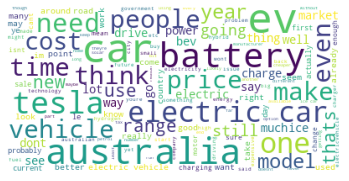

In [17]:
# Create a word frequency series. (This is a pandas series)
word_frequency = pd.Series(' '.join(combined['text_lemmatized']).split()).value_counts()
from PIL import Image
from wordcloud import WordCloud
corpus = list(combined['text_lemmatized'])

wordcloud = WordCloud(background_color='white', max_words=200, max_font_size=50, random_state=42).generate(str(corpus))

fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [20]:
#As we can see in the above corpus we have to remove some of the common words which are not giving any improvements to the analysis.
#As tesla is the only electric vehicle succeeded factory we can remove the tesla from the analysis.
common_words = ["tesla", "electric", "ev", "australia", "vehicle", "car", "electricvehicles", "electriccars", "electricvehicle"]

combined['text_lemmatized'] = combined['text_lemmatized'].apply(lambda x: " ".join(x for x in x.split() if x not in common_words))
combined.head(5)

,date,text,company,text_stemmed,text_lemmatized
0,2020-08-05,brilliant good car company affordable electric...,Twitter,brilliant good car compani afford electriccar ...,brilliant good company affordable imported jap...
1,2020-08-05,time australia wake risk becoming cuba south p...,Twitter,time australia wake risk becom cuba south paci...,time wake risk becoming cuba south pacific tou...
2,2020-08-05,want see stock appearing race car not hybrid f...,Twitter,want see stock appear race car not hybrid f2 s...,want see stock appearing race not hybrid f2 su...
3,2020-08-04,never thought id nerding car sale sites part w...,Twitter,never thought id nerd car sale site part work ...,never thought id nerding sale site part work r...
4,2020-08-04,australia peugeot missing mercedes eq got car ...,Twitter,australia peugeot miss merced eq got car year ...,peugeot missing mercedes eq got year award aus...


In [21]:
#Now we will again do the word frequency analysis
word_frequency = pd.Series(' '.join(combined['text_lemmatized']).split()).value_counts()
word_frequency[:10]

not        2502
battery    2025
would      1336
year       1325
like       1084
one        1078
get        1026
people      991
dont        973
need        888
dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


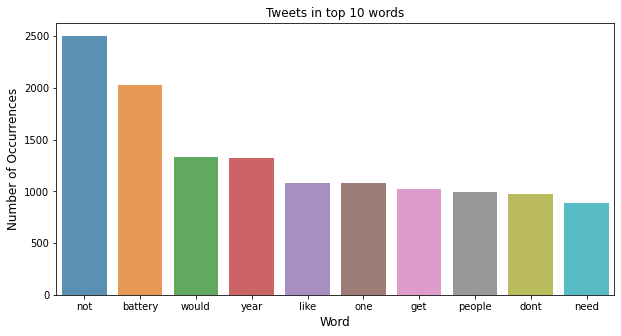

In [22]:
word_count  = word_frequency
word_count = word_count[:10,]
plt.figure(figsize=(10,5))
sns.barplot(word_count.index, word_count.values, alpha=0.8)
plt.title('Tweets in top 10 words')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Word', fontsize=12)
plt.show()

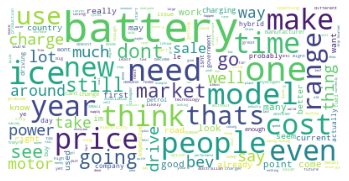

In [23]:
corpus = list(combined['text_lemmatized'])

wordcloud = WordCloud(background_color='white', max_words=200, max_font_size=50, random_state=42).generate(str(corpus))

fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [24]:
#Removing text_stemmed and normal text columns.
combined.pop("text")
combined.pop("text_stemmed")

0       brilliant good car compani afford electriccar ...
1       time australia wake risk becom cuba south paci...
2       want see stock appear race car not hybrid f2 s...
3       never thought id nerd car sale site part work ...
4       australia peugeot miss merced eq got car year ...
                              ...                        
6921    almostth cheapest model 70the 70d add allwheel...
6922    fair enough go site dont see list dont know mu...
6923    yeah design section littl confus probabl desig...
6924    look insid lamborghini jaw drop look alway lat...
6925    fair enough seem odd that alljust quick repli ...
Name: text_stemmed, Length: 6770, dtype: object

In [25]:
Twitter1 = combined.loc[combined['company'] == 'Twitter']
Whirlpool1 = combined.loc[combined['company'] == 'Whirlpool']
Ozbargain1 = combined.loc[combined['company'] == 'Ozbargain']
Reddit1 = combined.loc[combined['company'] == 'Reddit']

# Bi-Grams and Tri-grams

In [26]:
#Bi-grams
def get_ngrams(corpus, ngram_range=(2, 2)):
    vec1 = CountVectorizer(ngram_range=ngram_range, max_features=2000).fit(corpus)
    bag_of_words = vec1.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 

    words_freq = [(word, sum_words[0, idx]) for word, idx in vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq

In [27]:
bigrams_Twitter = get_ngrams(Twitter1['text_lemmatized'].tolist(), ngram_range=(2, 2))

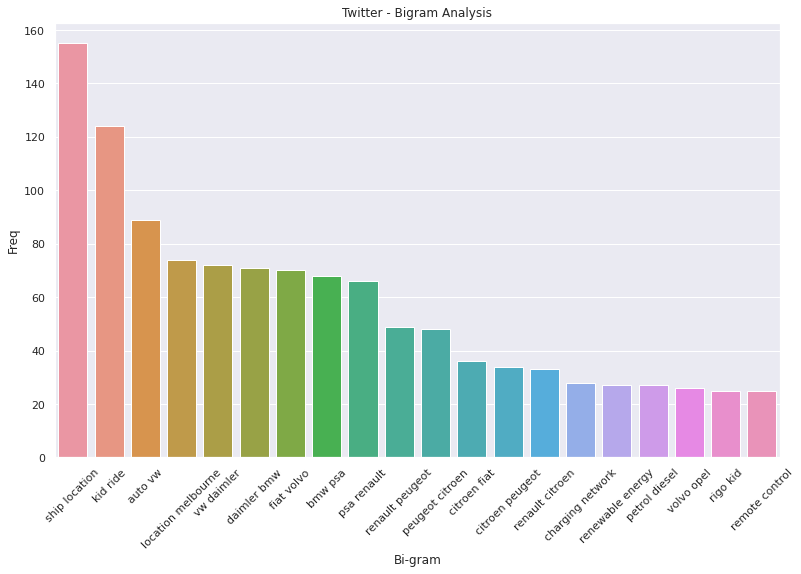

In [28]:
bigrams_twitter_df = pd.DataFrame(bigrams_Twitter)
bigrams_twitter_df.columns=["Bi-gram", "Freq"]

top_bigrams_to_show = 20

sns.set(rc={'figure.figsize':(13,8)})
h=sns.barplot(x="Bi-gram", y="Freq", data=bigrams_twitter_df[:top_bigrams_to_show])
h.set_xticklabels(h.get_xticklabels(), rotation=45)  # here rotation parameter shows the angle of your x-axis labels
plt.title('Twitter - Bigram Analysis')
plt.show()

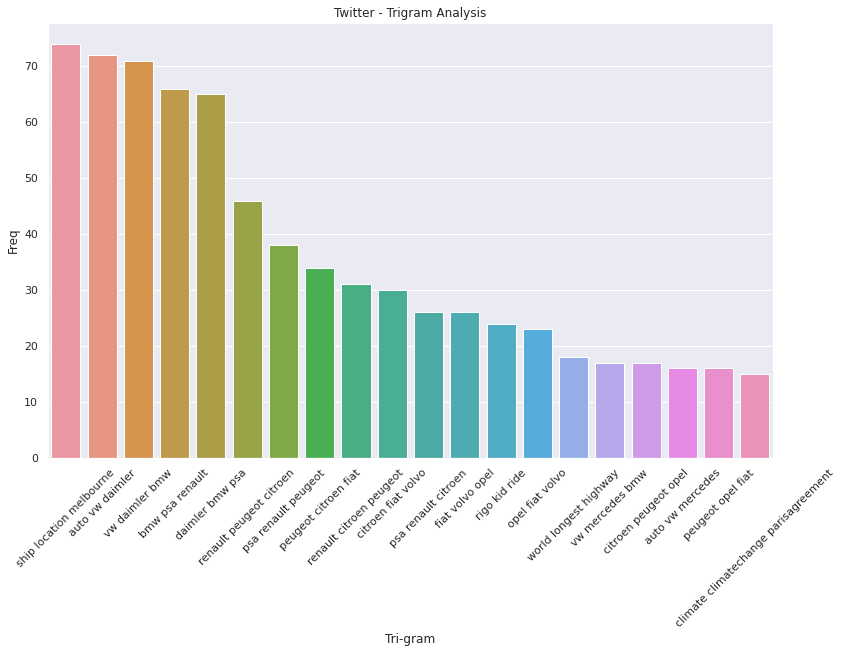

In [29]:
#Tri-grams
trigrams_Twitter = get_ngrams(Twitter1['text_lemmatized'].tolist(), ngram_range=(3, 3))

trigrams_twitter_df = pd.DataFrame(trigrams_Twitter)
trigrams_twitter_df.columns=["Tri-gram", "Freq"]

top_trigrams_to_show = 20

sns.set(rc={'figure.figsize':(13,8)})
h=sns.barplot(x="Tri-gram", y="Freq", data=trigrams_twitter_df[:top_trigrams_to_show])
h.set_xticklabels(h.get_xticklabels(), rotation=45)  # here rotation parameter shows the angle of your x-axis labels
plt.title('Twitter - Trigram Analysis')
plt.show()

# Temporal Analysis

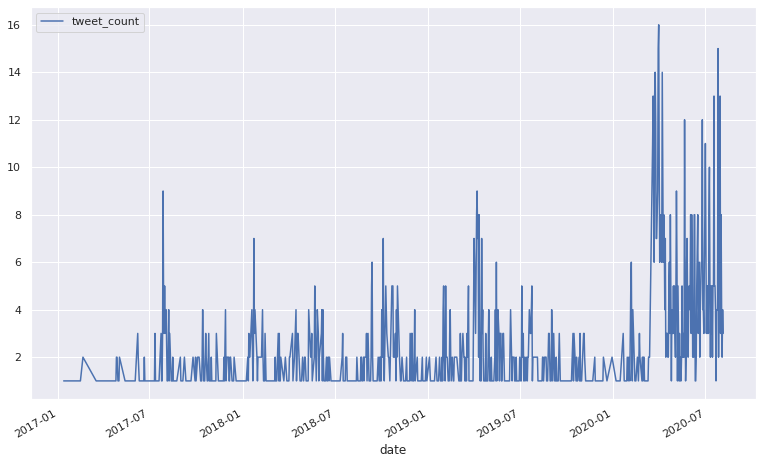

In [30]:
Twitter_date_wise = Twitter1.groupby(['date'])['text_lemmatized'].count().reset_index(name='tweet_count').set_index('date')
ax = Twitter_date_wise.plot()
plt.savefig('temporal_analysis_v2.png', dpi=800)

# Sentiment Analysis

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


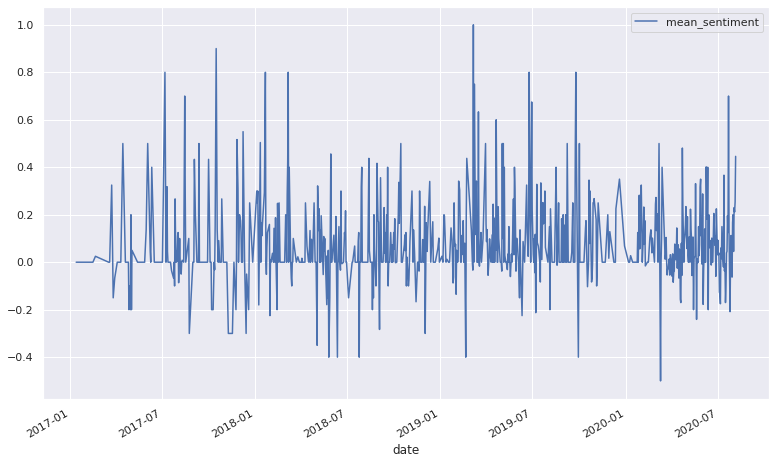

In [31]:
Twitter1['sentiment'] = Twitter1['text_lemmatized'].apply(lambda x: TextBlob(x).sentiment.polarity)
Twitter1.groupby(['date'])['sentiment'].mean()

Twitter_senti_date_wise = Twitter1.groupby(['date'])['sentiment'].mean().reset_index(name='mean_sentiment').set_index('date')

ax = Twitter_senti_date_wise.plot()
plt.savefig('temporal_sentiment_v2.png', dpi=800)

# Topic Modelling

In [32]:
import os

TEMP_FOLDER = tempfile.gettempdir()
print('Folder "{}" will be used to save temporary dictionary and corpus.'.format(TEMP_FOLDER))
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

corpus = list(Twitter1['text_lemmatized'])

Twitter_texts = [[word for word in str(document).split()] for document in corpus]

dictionary = corpora.Dictionary(Twitter_texts)

# Save the above dictionary as a local file for LDA model to access.
dictionary.save(os.path.join(TEMP_FOLDER, 'twitter.dict'))

corpus = [dictionary.doc2bow(text) for text in Twitter_texts]

2021-09-19 13:22:51,713 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2021-09-19 13:22:51,760 : INFO : built Dictionary(6265 unique tokens: ['affordable', 'brilliant', 'company', 'good', 'imported']...) from 1862 documents (total 24229 corpus positions)
2021-09-19 13:22:51,762 : INFO : saving Dictionary object under /tmp/twitter.dict, separately None
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
2021-09-19 13:22:51,771 : INFO : saved /tmp/twitter.dict


Folder "/tmp" will be used to save temporary dictionary and corpus.


In [35]:
tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus] 
total_topics = 10
lda = models.LdaModel(corpus, id2word=dictionary, num_topics=total_topics)
corpus_lda = lda[corpus_tfidf]
lda.show_topics(total_topics, num_words=6)

pyLDAvis.enable_notebook()
panel = pyLDAvis.gensim.prepare(lda, corpus_lda, dictionary, mds='tsne')
panel

2021-09-19 13:30:05,358 : INFO : collecting document frequencies
2021-09-19 13:30:05,361 : INFO : PROGRESS: processing document #0
2021-09-19 13:30:05,374 : INFO : calculating IDF weights for 1862 documents and 6264 features (23362 matrix non-zeros)
2021-09-19 13:30:05,394 : INFO : using symmetric alpha at 0.1
2021-09-19 13:30:05,395 : INFO : using symmetric eta at 0.1
2021-09-19 13:30:05,398 : INFO : using serial LDA version on this node
2021-09-19 13:30:05,413 : INFO : running online (single-pass) LDA training, 10 topics, 1 passes over the supplied corpus of 1862 documents, updating model once every 1862 documents, evaluating perplexity every 1862 documents, iterating 50x with a convergence threshold of 0.001000
2021-09-19 13:30:05,415 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is

PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
3      32.420952   8.115230       1        1  14.760717
9       0.648955  71.707100       2        1  13.705812
2      71.019684   9.971006       3        1  13.033665
8       3.785981  33.185135       4        1  12.379036
0     -42.666500  -9.222070       5        1  12.266046
1      -3.621689 -43.526516       6        1  11.275702
6      -3.632402  -4.171708       7        1   7.403485
5     -36.584400  35.804413       8        1   5.066906
4      44.391380  50.615383       9        1   5.063534
7      40.235809 -31.591665      10        1   5.045097, topic_info=          Term      Freq     Total Category  logprob  loglift
386       ship  7.000000  7.000000  Default  30.0000  30.0000
2349  location  7.000000  7.000000  Default  29.0000  29.0000
2001       kid  8.000000  8.000000  Default  28.0000  28.0000
965       ride  7.000000  7.000000  Default  27.0000  27.0000
2006       toy  3.000000  3.000000  Default  26.0000  26.0000
...        ...       ...       ...      ...      ...      ...
209      first  0.419790  5.062520  Topic10  -5.4107   0.4969
371   emission  0.375064  3.736459  Topic10  -5.5233   0.6880
17        sale  0.389201  6.246472  Topic10  -5.4863   0.2111
234     energy  0.408110  8.336774  Topic10  -5.4389  -0.0301
356        via  0.370265  5.928697  Topic10  -5.5362   0.2134

[783 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
2683      5  0.396395     12v
2683     10  0.396395     12v
2015      1  0.546222  across
579       1  0.379864  around
369       5  0.510804      au
...     ...       ...     ...
45        6  0.219204   would
23        1  0.185598    year
23        2  0.371195    year
23        3  0.185598    year
23        4  0.185598    year

[326 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 10, 3, 9, 1, 2, 7, 6, 5, 8])